# Ice edge detection & length estimation

Here, we go through a graphical approach to compute the length of the sea-ice edge.
We will also take into account segments that represent closed contours around holes or sea-ice patches in the open ocean and exclude these from the total length.

First, let's import the necessary libraries.

In [1]:
import cmocean
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm.auto import tqdm
import numpy as np
import xarray as xr
from pyproj import Geod
from shapely.geometry import LineString, Point
from skimage import measure

Next, we will load sea-ice concentration data from the TOPAZ4 data set.
The sea-ice edge is commonly defined as the 15% sea-ice concentration contour.
For this example, we take only a single time step from the data set.
We also constrain the domain slightly to focus only on the area of the Arctic where we have sea ice.

In [2]:
file = "sic_topaz4.nc"
data = xr.open_dataset(file).siconc.squeeze().sel(x=slice(-25,15), y=slice(-25, 20));
data

/home/markusritschel/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.DataArray 'siconc' (y: 361, x: 321)> Size: 464kB
[115881 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 8B 2021-09-04
    longitude  (y, x) float32 464kB ...
    latitude   (y, x) float32 464kB ...
  * x          (x) float32 1kB -25.0 -24.88 -24.75 -24.62 ... 14.75 14.88 15.0
  * y          (y) float32 1kB -25.0 -24.88 -24.75 -24.62 ... 19.75 19.88 20.0
Attributes:
    standard_name:  sea_ice_area_fraction
    units:          1
    grid_mapping:   stereographic
    cell_methods:   area: mean

## Using matplotlib

For a first try, we plot the 15% contour line via {func}`matplotlib.pyplot.contour` function.

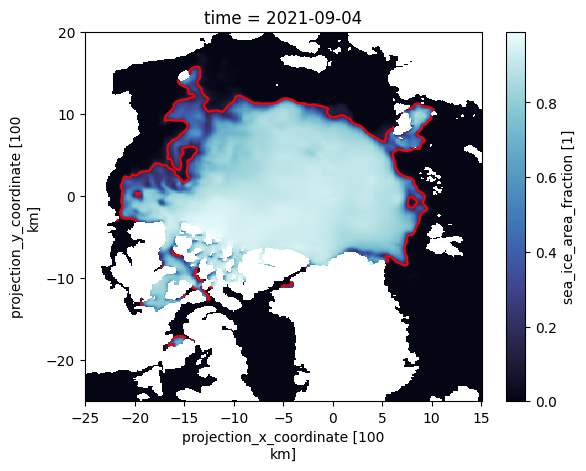

In [3]:
data.plot(cmap=cmocean.cm.ice)
CS = plt.contour(data.x, data.y, data, levels=[.15], colors='r')
contours = CS.allsegs[0]

The list `contours` containes the individual segments that {func}`~matplotlib.pyplot.contour` returns.

Next, we want to iterate over these segments, determine the length of each and check whether that feature is a closed ring or not.

Let's look at one such segment:

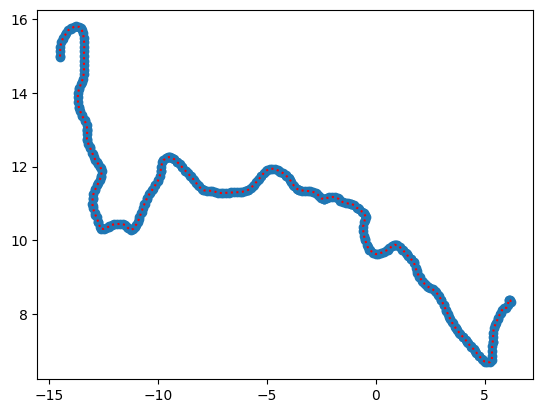

In [4]:
seg = contours[25]
plt.scatter(*seg.T)
x,y = seg.T
plt.plot(x, y, ls=':', c='r');

### Transform x/y coordinates from the `plt.contour` return to original lon/lat values

First, we build a trajectory of the segment x/y points

In [10]:
ds_trajectory = xr.Dataset({
    'x': ('trajectory', seg.T[0]),
    'y': ('trajectory', seg.T[1])
})
ds_trajectory

<xarray.Dataset> Size: 5kB
Dimensions:  (trajectory: 328)
Dimensions without coordinates: trajectory
Data variables:
    x        (trajectory) float64 3kB 6.211 6.182 6.125 ... -14.49 -14.5 -14.5
    y        (trajectory) float64 3kB 8.336 8.375 8.398 ... 15.12 15.0 14.97

which we then use to select the points from the original dataset. Keep in mind that not neccessarily all points that are returned by the {func}`~matplotlib.pyplot.contour` function actually exist in the dataset. We therefore use the option `method='nearest'`.

In [6]:
d = data.sel(x=ds_trajectory.x, y=ds_trajectory.y, method='nearest')

Let's also adjust the longitudes to be in the desired range.

In [7]:
adjusted_longitudes = np.where(d.longitude < 0, d.longitude + 360, d.longitude)
d['longitude'].values = adjusted_longitudes
# d = adjust_lons(d, 'longitude')

Now, we feed the longitude and latitude values to a {class}`shapely.LineString` object. {class}`~shapely.LineString` takes longitudes first, latitudes second.

In [8]:
# import xoak
# data.xoak.set_index(['longitude', 'latitude'], xoak.index.scipy_adapters.ScipyKDTreeAdapter)

# lons = data.xoak.sel(longitude=ds_trajectory.longitude, latitude=ds_trajectory.latitude)
# lons

In [9]:
lons = d.longitude.values
lats = d.latitude.values
ls = LineString(zip(lons, lats))

Plotting now the longitude and latitude values should give us the same result as the segment that {func}`~matplotlib.pyplot.contour` returned.

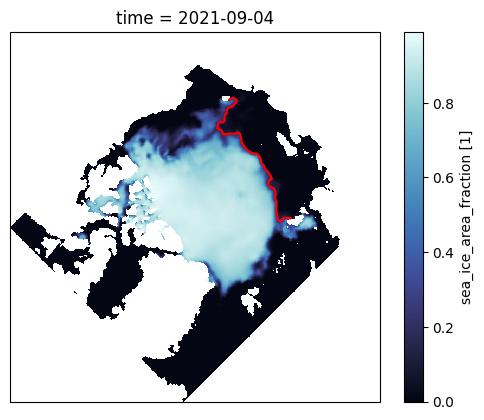

In [11]:
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
data.plot(x='longitude', y='latitude', cmap=cmocean.cm.ice, ax=ax, transform=ccrs.PlateCarree())
ax.plot(lons, lats, transform=ccrs.PlateCarree(), c='r');

And we can also check the feature for being a closed feature (ring) and compute its length:

In [12]:
geod = Geod(ellps="WGS84")
seg_len = geod.geometry_length(ls)/1e3

print(f"Is ring: {ls.is_ring}")
print(f"Segment length: {seg_len:.3f} km")

Is ring: False
Segment length: 3294.583 km


Great 💪 🚀

```{admonition} Calculating the length
:class: note
There are different ways to determine the length of a trajectory on Earth. Here, we use {meth}`pyproj.Geod.geometry_length`. A comparison of different methods can be found [here](calculating-distances).
```

### Apply it to the whole set of segments
Now, we can iterate over all segments and calculate the length of each segment and check it for being a ring (closed feature).

  0%|          | 0/32 [00:00<?, ?it/s]

53 km (skip - too short)
41 km (skip - too short)
12 km (skip - too short)
12 km (skip - too short)
0 km (skip - too short)
59 km (skip - too short)
12 km (skip - too short)
30 km (skip - too short)
25 km (skip - too short)
12 km (skip - too short)
59 km (skip - too short)
42 km (skip - too short)
12 km (skip - too short)
25 km (skip - too short)
0 km (skip - too short)
29 km (skip - too short)
0 km (skip - too short)
12 km (skip - too short)
359 km (skip - is ring)
118 km (skip - is ring)
Total length: 12631.450 km


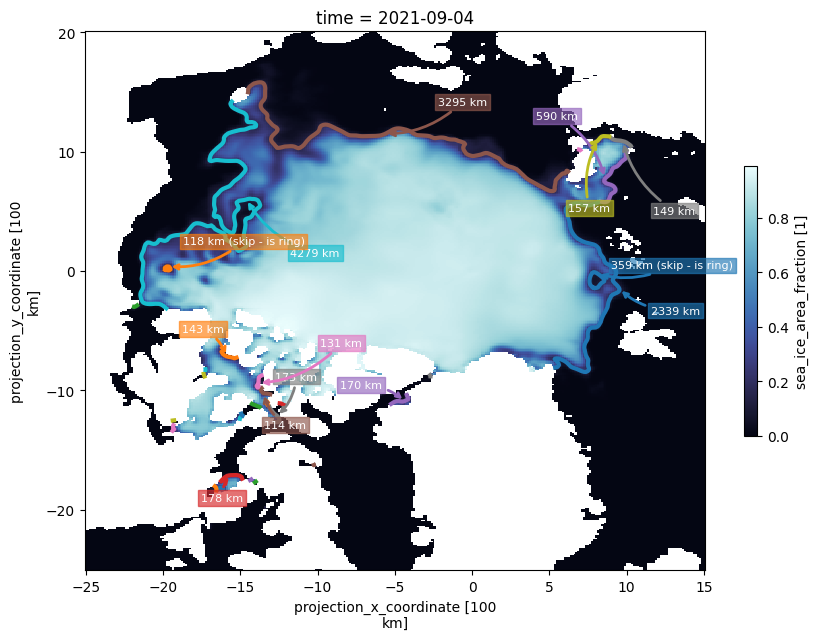

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
data.plot(ax=ax, zorder=-10, cmap=cmocean.cm.ice, cbar_kwargs={'shrink': .5})

total_edge_length = []  # <-- Will contain the total length of the sea-ice edge, excluding the ring elements
for seg in tqdm(contours):
    # p = ax.plot(seg[:, 0], seg[:, 1], linewidth=3)
    p = ax.plot(*seg.T, linewidth=3)
    this_color = p[0].get_color()

    # lons = interpn((data.y, data.x), data.longitude.values, np.fliplr(seg))
    # lats = interpn((data.y, data.x), data.latitude.values, np.fliplr(seg))
    # lons = griddata(np.array(data.y, data.x), data.longitude.values, seg, method='cubic')
    # lats = griddata(np.array(data.y, data.x), data.latitude.values, seg, method='cubic')
    
    ds_trajectory = xr.Dataset({
        'x': ('trajectory', seg.T[0]),
        'y': ('trajectory', seg.T[1])
    })
    d = data.sel(x=ds_trajectory.x, y=ds_trajectory.y, method='nearest')
    adjusted_longitudes = np.where(d.longitude < 0, d.longitude + 360, d.longitude)
    d['longitude'].values = adjusted_longitudes
    # d = adjust_lons(d, 'longitude')

    lons = d.longitude.values
    lats = d.latitude.values
    ls = LineString(zip(lons, lats))
    
    geod = Geod(ellps="WGS84")
    seg_len = geod.geometry_length(ls)/1e3
        
    total_edge_length.append(seg_len)
    s = f"{seg_len:.0f} km"

    # Skip if polygon is shorter than 100 km
    if seg_len < 100:
        s += " (skip - too short)"
        print(s)
        continue
    # Also don't include segment in total length if polygon is ring and not around the pole
    elif ls.is_ring and not ls.contains(Point(0,0)):
        s += " (skip - is ring)"
        print(s)

    # Plot segments and annotations
    xy = seg[len(seg)//2,:]   # the middle coordinate value of the segment
    t = plt.annotate(s, xy, xytext=seg.mean(axis=0)+(np.random.randint(-6,6), np.random.randint(-6,6)),
                     arrowprops=dict(arrowstyle="->",
                                     edgecolor=this_color,
                                     lw=2,
                                     connectionstyle="arc3,rad=-0.2"), 
                     fontsize='8', c='w')
    t.set_bbox(dict(facecolor=this_color, alpha=0.65, edgecolor=this_color, pad=2))

# plt.savefig("/home/u/u300917/sea-ice-edge-length.png", dpi=300)
print(f"Total length: {np.sum(total_edge_length):.3f} km")

### Are the numbers reasonable?
For a comparison: 

Greenland is approximately 2,670 kilometers (1,660 miles) long from its southernmost point to its northernmost point, as measured along the longitudinal line running through the center of the island. 

Novaya Zemlya is approximately 650 kilometers (404 miles) long from its northernmost point to its southernmost point.

## Using scikit-image

In a next approach, we use {func}`skimage.measure.find_contours`.

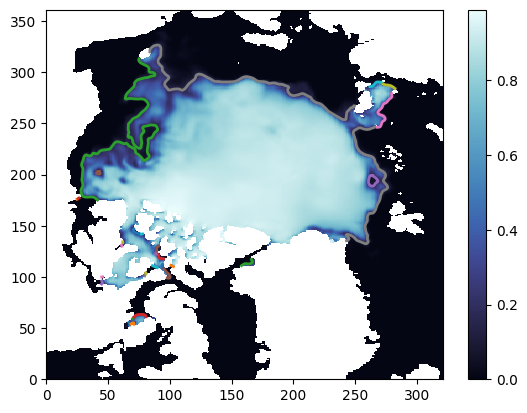

In [14]:
contours = measure.find_contours(data.values, 0.15)

plt.pcolormesh(data, cmap=cmocean.cm.ice)
plt.colorbar()

for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2);

```{admonition} Important
Note that {func}`~skimage.measure.find_contours` returns the contours in axis coordinates, i.e. they origin at 0.
Hence, we need to map them back to data coordinates.
```

In [15]:
def mapme(x, y):
    x_ = ((data.x.max() - data.x.min()) / (data.x.size)).values * x
    y_ = ((data.y.max() - data.y.min()) / (data.y.size)).values * y
    x_ +=  data.x.min().values
    y_ +=  data.y.min().values
    return x_, y_

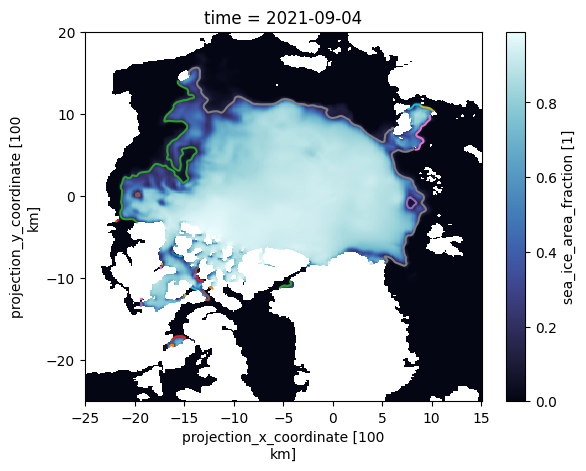

In [16]:
data.plot(cmap=cmocean.cm.ice)

for contour in contours:
    seg_y, seg_x = contour.T
    seg_x, seg_y = mapme(seg_x, seg_y)
    plt.plot(seg_x, seg_y);

  0%|          | 0/30 [00:00<?, ?it/s]

24 km (skip - too short)
60 km (skip - too short)
12 km (skip - too short)
46 km (skip - too short)
12 km (skip - too short)
17 km (skip - too short)
17 km (skip - too short)
59 km (skip - too short)
35 km (skip - too short)
30 km (skip - too short)
35 km (skip - too short)
79 km (skip - too short)
12 km (skip - too short)
12 km (skip - too short)
35 km (skip - too short)
12 km (skip - too short)
12 km (skip - too short)
402 km (skip - is ring)
133 km (skip - is ring)
Total length: 12843.677 km


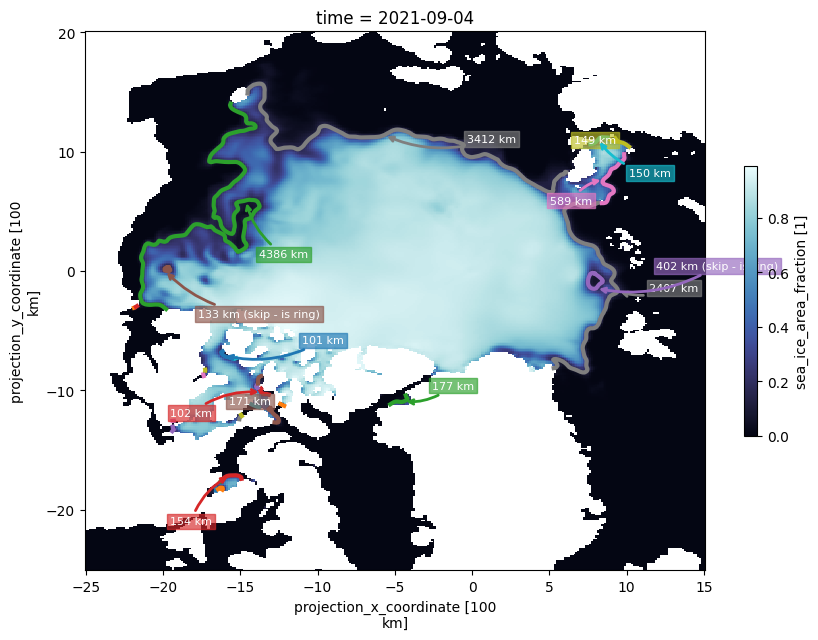

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
data.plot(ax=ax, cmap=cmocean.cm.ice, cbar_kwargs={'shrink': .5})

total_edge_length = []  # <-- Will contain the total length of the sea-ice edge, excluding the ring elements
for seg in tqdm(contours):
    # p = ax.plot(seg[:, 0], seg[:, 1], linewidth=3)
    seg_x, seg_y = np.fliplr(seg).T
    seg_x, seg_y = mapme(seg_x, seg_y)
    seg = np.array([seg_x, seg_y]).T

    p = ax.plot(*seg.T, linewidth=3)
    this_color = p[0].get_color()

    # lons = interpn((data.y, data.x), data.longitude.values, np.fliplr(seg))
    # lats = interpn((data.y, data.x), data.latitude.values, np.fliplr(seg))
    # lons = griddata(np.array(data.y, data.x), data.longitude.values, seg, method='cubic')
    # lats = griddata(np.array(data.y, data.x), data.latitude.values, seg, method='cubic')
    
    ds_trajectory = xr.Dataset({
        'x': ('trajectory', seg.T[0]),
        'y': ('trajectory', seg.T[1])
    })
    d = data.sel(x=ds_trajectory.x, y=ds_trajectory.y, method='nearest')
    adjusted_longitudes = np.where(d.longitude < 0, d.longitude + 360, d.longitude)
    d['longitude'].values = adjusted_longitudes
    # d = adjust_lons(d, 'longitude')

    lons = d.longitude.values
    lats = d.latitude.values
    ls = LineString(zip(lons, lats))
    
    geod = Geod(ellps="WGS84")
    seg_len = geod.geometry_length(ls)/1e3
        
    total_edge_length.append(seg_len)
    s = f"{seg_len:.0f} km"

    # Skip if polygon is shorter than 100 km
    if seg_len < 100:
        s += " (skip - too short)"
        print(s)
        continue
    # Also don't include segment in total length if polygon is ring and not around the pole
    elif ls.is_ring and not ls.contains(Point(0,0)):
        s += " (skip - is ring)"
        print(s)
    
    # seg = seg.T

    # Plot segments and annotations
    xy = seg[len(seg)//2,:]   # the middle coordinate value of the segment
    t = plt.annotate(s, xy, xytext=seg.mean(axis=0)+(np.random.randint(-6,6), np.random.randint(-6,6)),
                     arrowprops=dict(arrowstyle="->",
                                     edgecolor=this_color,
                                     lw=2,
                                     connectionstyle="arc3,rad=-0.2"), 
                     fontsize='8', c='w')
    t.set_bbox(dict(facecolor=this_color, alpha=0.65, edgecolor=this_color, pad=2))

# plt.savefig("/home/u/u300917/sea-ice-edge-length.png", dpi=300)
print(f"Total length: {np.sum(total_edge_length):.3f} km")

## Finally, plot it on a map with correct stereographic projection

TBD

Total length: nan km


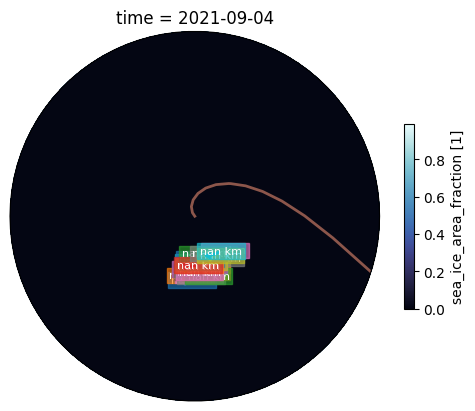

In [18]:
from my_code_base.plot.maps import *

ax = plt.subplot(projection=ccrs.NorthPolarStereo())
# data = fix_overlap(data, ax, lon_name='longitude', lat_name='latitude')
# ax.polar.lat_limits = (65, 90)
# ax.polar.add_features()
data.plot(ax=ax, x='longitude', y='latitude', cmap=cmocean.cm.ice, cbar_kwargs={'shrink':.5}, transform=ccrs.PlateCarree())
# plt.pcolormesh(data.x, data.y, data, cmap=cmocean.cm.ice)
# plt.colorbar(shrink=.5)

total_edge_length = []
for seg in contours:
    # p = ax.plot(seg[:, 1], seg[:, 0], linewidth=3)
    # this_color = p[0].get_color()
    
    seg_x, seg_y = np.fliplr(seg).T
    seg_x, seg_y = mapme(seg_x, seg_y)
    seg = np.array([seg_x, seg_y])#.T
    
    # p = ax.plot(seg_x, seg_y, linewidth=3, transform=ccrs.PlateCarree())
    # this_color = p[0].get_color()

    ds_trajectory = xr.Dataset({
        'x': ('trajectory', seg_x),
        'y': ('trajectory', seg_y)
    })

    d = data.sel(x=ds_trajectory.x, y=ds_trajectory.y, method='nearest')
    adjusted_longitudes = np.where(d.longitude < 0, d.longitude + 360, d.longitude)
    d['longitude'].values = adjusted_longitudes

    # d = adjust_lons(d, 'longitude')
    lons = d.longitude.values
    lats = d.latitude.values
    ls = LineString(zip(lons, lats))

    p = ax.plot(lons, lats, linewidth=2, transform=ccrs.PlateCarree())
    this_color = p[0].get_color()
  
    # TODO: Check the difference between the following two variants!
    # Var 1
    geod = Geod(ellps="WGS84")
    seg_len = geod.geometry_length(ls)/1e3
    
    total_edge_length.append(seg_len)

    s = f"{seg_len:.0f} km"
    # Skip if polygon is ring and not around the pole
    if ls.is_ring and not ls.contains(Point(0,0)):
        s = "skip (is ring)"
        continue
    # also skip if polygon is shorter than 100 km
    elif seg_len < 100:
        s += " (skip)"
        print(s)
        continue

    # seg = np.fliplr(seg)
    seg = seg.T

    #plt.text(lons.mean(), lats.mean(), s)
    xy = seg[len(seg)//2,:]
    t = plt.annotate(s, xy, xytext=seg.mean(axis=0)+(np.random.randint(-6,6), np.random.randint(-6,6)),
                     arrowprops=dict(arrowstyle="->",
                                     edgecolor=this_color,
                                     lw=2,
                                     connectionstyle="arc3,rad=-0.2"), 
                     fontsize='8', c='w', transform=ccrs.PlateCarree())
    t.set_bbox(dict(facecolor=this_color, alpha=0.65, edgecolor=this_color, pad=2))


# plt.savefig("/home/u/u300917/sea-ice-edge-length.png", dpi=300)
print(f"Total length: {np.sum(total_edge_length):.3f} km")

## Plot `ls` 

  0%|          | 0/32 [00:00<?, ?it/s]

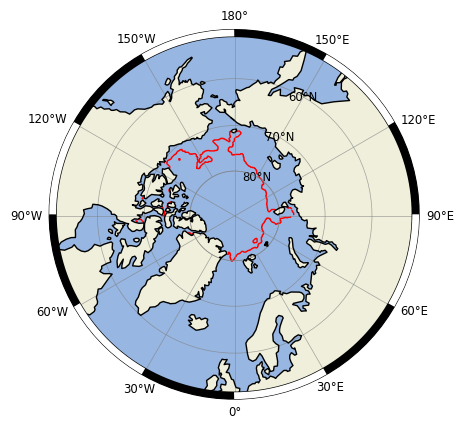

In [40]:
from my_code_base.plot.maps import *

ax = plt.subplot(projection=ccrs.NorthPolarStereo())

# data_ = data.rename({'longitude':'lon', 'latitude':'lat'})
# data_ = fix_overlap(data_, ax)
# data_.plot.contour(x='lon', y='lat', ax=ax, levels=[.15], colors=['r'], zorder=10, alpha=.8)

for seg in tqdm(contours):
    ds_trajectory = xr.Dataset({
        'x': ('trajectory', seg.T[0]),
        'y': ('trajectory', seg.T[1])
    })

    d = data.sel(x=ds_trajectory.x, y=ds_trajectory.y, method='nearest')
    adjusted_longitudes = np.where(d.longitude < 0, d.longitude + 360, d.longitude)
    d['longitude'].values = adjusted_longitudes

    # d = adjust_lons(d, 'longitude')
    lons = d.longitude.values
    lats = d.latitude.values
    ls = LineString(zip(lons, lats))
    # ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=1)
    from cartopy.mpl.patch import geos_to_path
    from matplotlib.patches import PathPatch
    path, = geos_to_path(ls)
    patch = PathPatch(path, transform=ccrs.Geodetic(), edgecolor='r', facecolor='none')
    ax.add_patch(patch)
ax.polar.add_features()
